# Summed Position Counts

This notebook is used to create a table of position counts where all of the samples are summed together rather than kept as seperate samples. 

This notebook needs considerable reworking

In [62]:
# Loading up the path to my tools file. 
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [63]:
# Loading up required packages
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
from Bio import SeqIO
import numpy
import pandas as pd
from scipy import stats
import keegan_analysis_tools as kat
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import os
from scipy.sparse.linalg import lsqr

In [113]:
# Define the path to important files. 
data_path = '/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/mmus/'
csv_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts_codon_resolution/mmus/'
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts_codon_resolution/mmus/'
image_path = '/home/keeganfl/Desktop/Work_Fall_2021/Presentation_figures/'
gtf_name = "mm10.refGene.gtf"
mutation = "Fmr1"

## Load up the transcript data

In [114]:
# load the transcript annotations from the GTF file.
# GTF2_TranscriptAssembler returns an iterator, so here we convert it to a list.
transcripts = list(GTF2_TranscriptAssembler(open(data_path + gtf_name),return_type=Transcript))

In [66]:
# Remove non-protein coding transcripts from transcripts list. 
protein_coding = []
for transcript in transcripts:
    if transcript.attr['transcript_biotype'] == 'protein_coding':
        protein_coding.append(transcript)

In [67]:
# clear up some memory by deleting original transcript list
transcripts.clear()

## Create the summed samples

In [115]:
# get a list of all the files you want to sum together. 
all_samples = os.listdir(csv_path)

In [116]:
# Split up the files you want to sum together into mutants and controls
mutant_samples = []
control_samples = []
for sample in all_samples:
    if sample.startswith("Fmr1") == True:
        mutant_samples.append(sample)
    elif sample.startswith("control") == True:
        control_samples.append(sample)

In [117]:
# Create a function that will load up the necessary count arrays and sum them together
def get_summed_array(samples):
    count_list = []
    for s in samples:
        count_list.append(kat.load_count_positions(s, csv_path))
    
    # Convert count lists to numpy arrays so they can be quickly and easily summmed. 
    for count, i in zip(count_list, list(range(len(count_list)))):
        count_list[i] = np.array(count, dtype=object)
    
    # Sum all of your newly made count arrays together. 
    summed_counts = sum(count_list)

    # Convert everything back to lists so that you can easily make your data tables. 
    summed_counts = summed_counts.tolist()
    for i, j in zip(summed_counts, list(range(len(summed_counts)))):
        summed_counts[j] = i.tolist()
    return summed_counts

In [118]:
# Load up the summed count arrays
mutant_summed_array = get_summed_array(mutant_samples)
control_summed_array = get_summed_array(control_samples)

## Alter the summed arrays to be saved as CSVs

In [72]:
def load_array_as_csv(transcripts, summed_array):
    
    # Create a list that contains all of the gene_ids and transcript_ids of the transcripts
    gene_id = []
    transcript_id = []

    for transcript in transcripts:
        gene_id.append(transcript.attr["gene_name"])
        transcript_id.append(transcript.attr["transcript_id"])
    
    # Insert the gene ids and transcript ids into the codon_count list. 
    for i, j in zip(summed_array, range(len(gene_id))):
        i.insert(0,gene_id[j])
        i.insert(0,transcript_id[j])
        
    # Calculate the longest cds region in our new list of counts
    l_tr = kat.find_max_list(summed_array)

    # Define a header that includes labels for the transcript and gene ID as 
    # well as numbers that index the cds region position.
    header=["transcript_id","gene_id"]+list(range(l_tr))

    # insert that header into our counts list. 
    summed_array.insert(0,header)
    return summed_array

In [73]:
# Convert the summed count arrays to the proper csv format
mutant_summed_array = load_array_as_csv(protein_coding, mutant_summed_array)
control_summed_array = load_array_as_csv(protein_coding, control_summed_array)

In [74]:
# save both summed count arrays as CSVs
with open(save_path + 'mutant_summed_counts.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(mutant_summed_array)
    
with open(save_path + 'control_summed_counts.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(control_summed_array)

## Choose the gene of interest and smooth out the array.

In [129]:
# Choosing a gene of interest to calculate the elongation rates of. 
# Get the transcript and vector for the gene of interest.
my_gene = 'Shank2'
my_transcript, my_vec_mutant, my_vec_control, index = kat.find_trans_mmus(my_gene, 
                                           transcripts, mutant_summed_array, control_summed_array)

In [130]:
# Create a vector that just reflects the positions along the transcript
my_position = np.array(list(range(len(my_vec_mutant))))

In [131]:
my_vec_mutant = np.array(my_vec_mutant)
my_vec_control = np.array(my_vec_control)

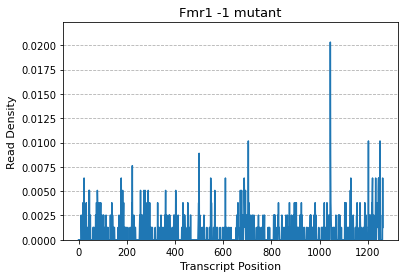

In [135]:
maxi = max([max(my_vec_mutant/sum(my_vec_mutant)), max(my_vec_control/sum(my_vec_control))])
#plt.bar(list(range(len(my_vec_mutant))),my_vec_mutant/sum(my_vec_mutant), width = 2.8)
plt.plot(my_vec_mutant/sum(my_vec_mutant))
plt.ylim([0,maxi*1.1])
plt.title("Fmr1 -1 mutant", fontsize = 13)
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.ylabel("Read Density", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.savefig(image_path + my_gene + '_mutant_array.pdf')

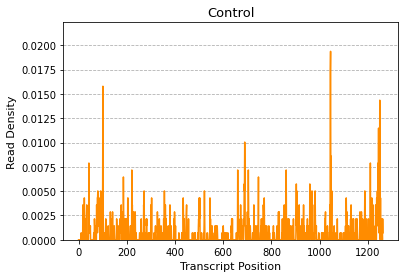

In [134]:
#plt.bar(list(range(len(my_vec_control))),my_vec_control/(sum(my_vec_control)), width = 2.8, color = "darkorange")
plt.plot(my_vec_control/sum(my_vec_control), color = "darkorange")
plt.ylim([0,maxi*1.1])
plt.title("Control", fontsize = 13)
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.ylabel("Read Density", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.savefig(image_path + my_gene + '_control_array.pdf')

In [136]:
smoothed_vec_m, cumul_m = kat.get_smoothed_vector(np.array(my_vec_mutant))
smoothed_vec_c, cumul_c = kat.get_smoothed_vector(np.array(my_vec_control))

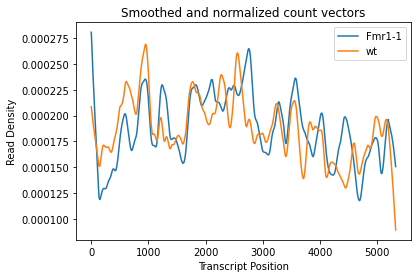

In [96]:
plt.plot(smoothed_vec_m, label = "Fmr1-1")
#plt.plot(my_vec_mutant/sum(my_vec_mutant))
plt.plot(smoothed_vec_c, label = "wt")
plt.ylabel("Read Density")
plt.xlabel("Transcript Position")
plt.title("Smoothed and normalized count vectors")
plt.legend()

## Plot and calculate the correlation of the cumulative sum * The transcript position

In [137]:
ks = max(abs(cumul_m - cumul_c))
ks

0.03749150888363151

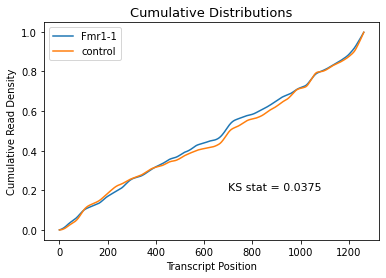

In [140]:
plt.plot(my_position, cumul_m, label = "Fmr1-1")
plt.plot(my_position, cumul_c, label = "control")
plt.text(700, 0.2, "KS stat = "+ str(round(ks, 4)), fontsize = 11)
plt.ylabel("Cumulative Read Density")
plt.xlabel("Transcript Position")
plt.title("Cumulative Distributions", fontsize = 13)
plt.legend()
plt.savefig(image_path + my_gene + '_cumulative.pdf')